In [1]:
#| default_exp models.fedformer

# FEDformer

The FEDformer model tackles the challenge of finding reliable dependencies on intricate temporal patterns of long-horizon forecasting.

The architecture has the following distinctive features:
- In-built progressive decomposition in trend and seasonal components based on a moving average filter.
- Frequency Enhanced Block and Frequency Enhanced Attention to perform attention in the sparse representation on basis such as Fourier transform.
- Classic encoder-decoder proposed by Vaswani et al. (2017) with a multi-head attention mechanism.

The FEDformer model utilizes a three-component approach to define its embedding:
- It employs encoded autoregressive features obtained from a convolution network.
- Absolute positional embeddings obtained from calendar features are utilized.

**References**<br>
- [Zhou, Tian, Ziqing Ma, Qingsong Wen, Xue Wang, Liang Sun, and Rong Jin.. "FEDformer: Frequency enhanced decomposed transformer for long-term series forecasting"](https://proceedings.mlr.press/v162/zhou22g.html)<br>

![Figure 1. FEDformer Architecture.](imgs_models/fedformer.png)

In [2]:
#| export
import numpy as np
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

from neuralforecast.common._modules import DataEmbedding
from neuralforecast.common._base_windows import BaseWindows

from neuralforecast.losses.pytorch import MAE

## 1. Auxiliary functions

In [3]:
#| export
class MovingAvg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(MovingAvg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class SeriesDecomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(SeriesDecomp, self).__init__()
        self.MovingAvg = MovingAvg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.MovingAvg(x)
        res = x - moving_mean
        return res, moving_mean
    
class LayerNorm(nn.Module):
    """
    Special designed layernorm for the seasonal part
    """
    def __init__(self, channels):
        super(LayerNorm, self).__init__()
        self.layernorm = nn.LayerNorm(channels)

    def forward(self, x):
        x_hat = self.layernorm(x)
        bias = torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1)
        return x_hat - bias


class AutoCorrelationLayer(nn.Module):
    def __init__(self, correlation, hidden_size, n_head, d_keys=None,
                 d_values=None):
        super(AutoCorrelationLayer, self).__init__()

        d_keys = d_keys or (hidden_size // n_head)
        d_values = d_values or (hidden_size // n_head)

        self.inner_correlation = correlation
        self.query_projection = nn.Linear(hidden_size, d_keys * n_head)
        self.key_projection = nn.Linear(hidden_size, d_keys * n_head)
        self.value_projection = nn.Linear(hidden_size, d_values * n_head)
        self.out_projection = nn.Linear(d_values * n_head, hidden_size)
        self.n_head = n_head

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_head

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_correlation(
            queries,
            keys,
            values,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

In [4]:
#| export
class EncoderLayer(nn.Module):
    """
    FEDformer encoder layer with the progressive decomposition architecture
    """
    def __init__(self, attention, hidden_size, conv_hidden_size=None, MovingAvg=25, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        conv_hidden_size = conv_hidden_size or 4 * hidden_size
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=conv_hidden_size, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=conv_hidden_size, out_channels=hidden_size, kernel_size=1, bias=False)
        self.decomp1 = SeriesDecomp(MovingAvg)
        self.decomp2 = SeriesDecomp(MovingAvg)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)
        x, _ = self.decomp1(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        res, _ = self.decomp2(x + y)
        return res, attn


class Encoder(nn.Module):
    """
    FEDformer encoder
    """
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns


class DecoderLayer(nn.Module):
    """
    FEDformer decoder layer with the progressive decomposition architecture
    """
    def __init__(self, self_attention, cross_attention, hidden_size, c_out, conv_hidden_size=None,
                 MovingAvg=25, dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        conv_hidden_size = conv_hidden_size or 4 * hidden_size
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=conv_hidden_size, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=conv_hidden_size, out_channels=hidden_size, kernel_size=1, bias=False)
        self.decomp1 = SeriesDecomp(MovingAvg)
        self.decomp2 = SeriesDecomp(MovingAvg)
        self.decomp3 = SeriesDecomp(MovingAvg)
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Conv1d(in_channels=hidden_size, out_channels=c_out, kernel_size=3, stride=1, padding=1,
                                    padding_mode='circular', bias=False)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x, trend1 = self.decomp1(x)
        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])
        x, trend2 = self.decomp2(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        x, trend3 = self.decomp3(x + y)

        residual_trend = trend1 + trend2 + trend3
        residual_trend = self.projection(residual_trend.permute(0, 2, 1)).transpose(1, 2)
        return x, residual_trend


class Decoder(nn.Module):
    """
    FEDformer decoder
    """
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, trend=None):
        for layer in self.layers:
            x, residual_trend = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)
            trend = trend + residual_trend

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x, trend

In [5]:
#| export
def get_frequency_modes(seq_len, modes=64, mode_select_method='random'):
    """
    Get modes on frequency domain:
        'random' for sampling randomly
        'else' for sampling the lowest modes;
    """
    modes = min(modes, seq_len//2)
    if mode_select_method == 'random':
        index = list(range(0, seq_len // 2))
        np.random.shuffle(index)
        index = index[:modes]
    else:
        index = list(range(0, modes))
    index.sort()
    return index


class FourierBlock(nn.Module):
    def __init__(self, in_channels, out_channels, seq_len, modes=0, mode_select_method='random'):
        super(FourierBlock, self).__init__()
        """
        Fourier block
        """
        # get modes on frequency domain
        self.index = get_frequency_modes(seq_len, modes=modes, mode_select_method=mode_select_method)

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(8, in_channels // 8, out_channels // 8, len(self.index), dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bhi,hio->bho", input, weights)

    def forward(self, q, k, v, mask):
        # size = [B, L, H, E]
        B, L, H, E = q.shape
        
        x = q.permute(0, 2, 3, 1)
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x, dim=-1)
        # Perform Fourier neural operations
        out_ft = torch.zeros(B, H, E, L // 2 + 1, device=x.device, dtype=torch.cfloat)
        for wi, i in enumerate(self.index):
            out_ft[:, :, :, wi] = self.compl_mul1d(x_ft[:, :, :, i], self.weights1[:, :, :, wi])
        # Return to time domain
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return (x, None)

class FourierCrossAttention(nn.Module):
    def __init__(self, in_channels, out_channels, seq_len_q, seq_len_kv, modes=64, mode_select_method='random',
                 activation='tanh', policy=0):
        super(FourierCrossAttention, self).__init__()
        """
        Fourier Cross Attention layer
        """
        self.activation = activation
        self.in_channels = in_channels
        self.out_channels = out_channels
        # get modes for queries and keys (& values) on frequency domain
        self.index_q = get_frequency_modes(seq_len_q, modes=modes, mode_select_method=mode_select_method)
        self.index_kv = get_frequency_modes(seq_len_kv, modes=modes, mode_select_method=mode_select_method)

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(8, in_channels // 8, out_channels // 8, len(self.index_q), dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bhi,hio->bho", input, weights)

    def forward(self, q, k, v, mask):
        # size = [B, L, H, E]
        B, L, H, E = q.shape
        xq = q.permute(0, 2, 3, 1)  # size = [B, H, E, L]
        xk = k.permute(0, 2, 3, 1)
        #xv = v.permute(0, 2, 3, 1)

        # Compute Fourier coefficients
        xq_ft_ = torch.zeros(B, H, E, len(self.index_q), device=xq.device, dtype=torch.cfloat)
        xq_ft = torch.fft.rfft(xq, dim=-1)
        for i, j in enumerate(self.index_q):
            xq_ft_[:, :, :, i] = xq_ft[:, :, :, j]
        xk_ft_ = torch.zeros(B, H, E, len(self.index_kv), device=xq.device, dtype=torch.cfloat)
        xk_ft = torch.fft.rfft(xk, dim=-1)
        for i, j in enumerate(self.index_kv):
            xk_ft_[:, :, :, i] = xk_ft[:, :, :, j]

        # Attention mechanism on frequency domain
        xqk_ft = (torch.einsum("bhex,bhey->bhxy", xq_ft_, xk_ft_))
        if self.activation == 'tanh':
            xqk_ft = xqk_ft.tanh()
        elif self.activation == 'softmax':
            xqk_ft = torch.softmax(abs(xqk_ft), dim=-1)
            xqk_ft = torch.complex(xqk_ft, torch.zeros_like(xqk_ft))
        else:
            raise Exception('{} actiation function is not implemented'.format(self.activation))
        xqkv_ft = torch.einsum("bhxy,bhey->bhex", xqk_ft, xk_ft_)
        xqkvw = torch.einsum("bhex,heox->bhox", xqkv_ft, self.weights1)
        out_ft = torch.zeros(B, H, E, L // 2 + 1, device=xq.device, dtype=torch.cfloat)
        for i, j in enumerate(self.index_q):
            out_ft[:, :, :, j] = xqkvw[:, :, :, i]
        
        # Return to time domain
        out = torch.fft.irfft(out_ft / self.in_channels / self.out_channels, n=xq.size(-1))
        return (out, None)

## 2. Model

In [6]:
#| export
class FEDformer(BaseWindows):
    """ FEDformer

    The FEDformer model tackles the challenge of finding reliable dependencies on intricate temporal patterns of long-horizon forecasting.

    The architecture has the following distinctive features:
    - In-built progressive decomposition in trend and seasonal components based on a moving average filter.
    - Frequency Enhanced Block and Frequency Enhanced Attention to perform attention in the sparse representation on basis such as Fourier transform.
    - Classic encoder-decoder proposed by Vaswani et al. (2017) with a multi-head attention mechanism.

    The FEDformer model utilizes a three-component approach to define its embedding:
    - It employs encoded autoregressive features obtained from a convolution network.
    - Absolute positional embeddings obtained from calendar features are utilized.

    *Parameters:*<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
	`decoder_input_size_multiplier`: float = 0.5, .<br>
    `version`: str = 'Fourier', version of the model.<br>
    `modes`: int = 64, number of modes for the Fourier block.<br>
    `mode_select`: str = 'random', method to select the modes for the Fourier block.<br>
    `hidden_size`: int=128, units of embeddings and encoders.<br>
    `dropout`: float (0, 1), dropout throughout Autoformer architecture.<br>
    `n_head`: int=8, controls number of multi-head's attention.<br>
	`conv_hidden_size`: int=32, channels of the convolutional encoder.<br>
	`activation`: str=`GELU`, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid', 'GELU'].<br>
    `encoder_layers`: int=2, number of layers for the TCN encoder.<br>
    `decoder_layers`: int=1, number of layers for the MLP decoder.<br>
    `MovingAvg_window`: int=25, window size for the moving average filter.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module, instantiated validation loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=1024, number of windows to sample in each inference batch.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

    """
    # Class attributes
    SAMPLING_TYPE = 'windows'

    def __init__(self,
                 h: int, 
                 input_size: int,
                 stat_exog_list = None,
                 hist_exog_list = None,
                 futr_exog_list = None,
                 decoder_input_size_multiplier: float = 0.5,
                 version: str = 'Fourier',
                 modes: int = 64,
                 mode_select: str = 'random',
                 hidden_size: int = 128, 
                 dropout: float = 0.05,
                 n_head: int = 8,
                 conv_hidden_size: int = 32,
                 activation: str = 'gelu',
                 encoder_layers: int = 2, 
                 decoder_layers: int = 1,
                 MovingAvg_window: int = 25,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 5000,
                 learning_rate: float = 1e-4,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 start_padding_enabled = False,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 inference_windows_batch_size = 1024,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 **trainer_kwargs):
        super(FEDformer, self).__init__(h=h,
                                       input_size=input_size,
                                       hist_exog_list=hist_exog_list,
                                       stat_exog_list=stat_exog_list,
                                       futr_exog_list = futr_exog_list,
                                       loss=loss,
                                       valid_loss=valid_loss,
                                       max_steps=max_steps,
                                       learning_rate=learning_rate,
                                       num_lr_decays=num_lr_decays,
                                       early_stop_patience_steps=early_stop_patience_steps,
                                       val_check_steps=val_check_steps,
                                       batch_size=batch_size,
                                       windows_batch_size=windows_batch_size,
                                       valid_batch_size=valid_batch_size,
                                       inference_windows_batch_size=inference_windows_batch_size,
                                       start_padding_enabled=start_padding_enabled,
                                       step_size=step_size,
                                       scaler_type=scaler_type,
                                       num_workers_loader=num_workers_loader,
                                       drop_last_loader=drop_last_loader,
                                       random_seed=random_seed,
                                       **trainer_kwargs)
        # Architecture
        self.futr_input_size = len(self.futr_exog_list)
        self.hist_input_size = len(self.hist_exog_list)
        self.stat_input_size = len(self.stat_exog_list)

        if self.stat_input_size > 0:
            raise Exception('Autoformer does not support static variables yet')
        
        if self.hist_input_size > 0:
            raise Exception('Autoformer does not support historical variables yet')

        self.label_len = int(np.ceil(input_size * decoder_input_size_multiplier))
        if (self.label_len >= input_size) or (self.label_len <= 0):
            raise Exception(f'Check decoder_input_size_multiplier={decoder_input_size_multiplier}, range (0,1)')

        if activation not in ['relu', 'gelu']:
            raise Exception(f'Check activation={activation}')
        
        if n_head != 8:
            raise Exception('n_head must be 8')
        
        if version not in ['Fourier']:
            raise Exception('Only Fourier version is supported currently.')

        self.c_out = self.loss.outputsize_multiplier
        self.output_attention = False
        self.enc_in = 1 
        self.dec_in = 1
        
        self.decomp = SeriesDecomp(MovingAvg_window)

        # Embedding
        self.enc_embedding = DataEmbedding(c_in=self.enc_in,
                                           exog_input_size=self.hist_input_size,
                                           hidden_size=hidden_size, 
                                           pos_embedding=False,
                                           dropout=dropout)
        self.dec_embedding = DataEmbedding(self.dec_in,
                                           exog_input_size=self.hist_input_size,
                                           hidden_size=hidden_size, 
                                           pos_embedding=False,
                                           dropout=dropout)

        encoder_self_att = FourierBlock(in_channels=hidden_size,
                                        out_channels=hidden_size,
                                        seq_len=input_size,
                                        modes=modes,
                                        mode_select_method=mode_select)
        decoder_self_att = FourierBlock(in_channels=hidden_size,
                                        out_channels=hidden_size,
                                        seq_len=input_size//2+self.h,
                                        modes=modes,
                                        mode_select_method=mode_select)
        decoder_cross_att = FourierCrossAttention(in_channels=hidden_size,
                                                    out_channels=hidden_size,
                                                    seq_len_q=input_size//2+self.h,
                                                    seq_len_kv=input_size,
                                                    modes=modes,
                                                    mode_select_method=mode_select)

        self.encoder = Encoder(
            [
                EncoderLayer(
                    AutoCorrelationLayer(
                        encoder_self_att,
                        hidden_size, n_head),

                    hidden_size=hidden_size,
                    conv_hidden_size=conv_hidden_size,
                    MovingAvg=MovingAvg_window,
                    dropout=dropout,
                    activation=activation
                ) for l in range(encoder_layers)
            ],
            norm_layer=LayerNorm(hidden_size)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AutoCorrelationLayer(
                        decoder_self_att,
                        hidden_size, n_head),
                    AutoCorrelationLayer(
                        decoder_cross_att,
                        hidden_size, n_head),
                    hidden_size=hidden_size,
                    c_out=self.c_out,
                    conv_hidden_size=conv_hidden_size,
                    MovingAvg=MovingAvg_window,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(decoder_layers)
            ],
            norm_layer=LayerNorm(hidden_size),
            projection=nn.Linear(hidden_size, self.c_out, bias=True)
        )

    def forward(self, windows_batch):
        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        #insample_mask = windows_batch['insample_mask']
        #hist_exog     = windows_batch['hist_exog']
        #stat_exog     = windows_batch['stat_exog']
        futr_exog     = windows_batch['futr_exog']

        # Parse inputs
        insample_y = insample_y.unsqueeze(-1) # [Ws,L,1]
        if self.futr_input_size > 0:
            x_mark_enc = futr_exog[:,:self.input_size,:]
            x_mark_dec = futr_exog[:,-(self.label_len+self.h):,:]
        else:
            x_mark_enc = None
            x_mark_dec = None

        x_dec = torch.zeros(size=(len(insample_y),self.h, self.dec_in)).to(insample_y.device)
        x_dec = torch.cat([insample_y[:,-self.label_len:,:], x_dec], dim=1)
                
        # decomp init
        mean = torch.mean(insample_y, dim=1).unsqueeze(1).repeat(1, self.h, 1)
        zeros = torch.zeros([x_dec.shape[0], self.h, x_dec.shape[2]], device=insample_y.device)
        seasonal_init, trend_init = self.decomp(insample_y)
        # decoder input
        trend_init = torch.cat([trend_init[:, -self.label_len:, :], mean], dim=1)
        seasonal_init = torch.cat([seasonal_init[:, -self.label_len:, :], zeros], dim=1)
        # enc
        enc_out = self.enc_embedding(insample_y, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=None)
        # dec
        dec_out = self.dec_embedding(seasonal_init, x_mark_dec)
        seasonal_part, trend_part = self.decoder(dec_out, enc_out, x_mask=None, cross_mask=None,
                                                 trend=trend_init)
        # final
        dec_out = trend_part + seasonal_part

        forecast = self.loss.domain_map(dec_out[:, -self.h:])
        return forecast

In [7]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df

AirPassengersPanel, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

Seed set to 1
2023-11-01 22:32:01.560591: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-01 22:32:01.563465: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 22:32:01.611305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 22:32:01.611338: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 22:32:01.611374: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Atte

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Predicting: |                                                                                     | 0/? [00:00…

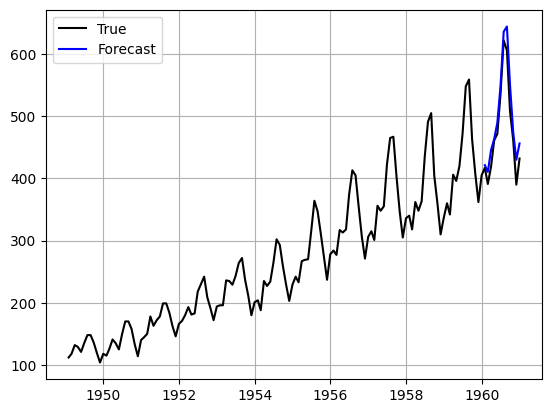

In [8]:
#| eval: false
model = FEDformer(h=12,
                 input_size=24,
                 modes=64,
                 hidden_size=64,
                 conv_hidden_size=128,
                 n_head=8,
                 loss=MAE(),
                 futr_exog_list=calendar_cols,
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=500,
                 batch_size=2,
                 windows_batch_size=32,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M',
)
nf.fit(df=Y_train_df, static_df=None, val_size=12)
forecasts = nf.predict(futr_df=Y_test_df)

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

if model.loss.is_distribution_output:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['FEDformer-median'], c='blue', label='median')
    plt.fill_between(x=plot_df['ds'][-12:], 
                    y1=plot_df['FEDformer-lo-90'][-12:].values, 
                    y2=plot_df['FEDformer-hi-90'][-12:].values,
                    alpha=0.4, label='level 90')
    plt.grid()
    plt.legend()
    plt.plot()
else:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['FEDformer'], c='blue', label='Forecast')
    plt.legend()
    plt.grid()

In [10]:
y_true = Y_test_df.y.values
y_hat = Y_hat_df['FEDformer'].values

from neuralforecast.losses.numpy import mae, mse

print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))

MAE:  21.278610229492188
MSE:  616.9501849608496
